In [ ]:
# 설치
!pip install langchain langgraph openai faiss-cpu pypdf unstructured tiktoken langchain_community pymupdf


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 22.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.2/145.2 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.3/302.3 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━

In [ ]:
import os
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.document_loaders import WebBaseLoader, PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains import RetrievalQA
from langchain.schema import Document
from typing import TypedDict, List

os.environ["OPENAI_API_KEY"] = "your-key"  # OpenAI 키 입력
llm = ChatOpenAI(model="gpt-4", temperature=0)
embedding = OpenAIEmbeddings()


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving samilpwc_retirement-pension.pdf to samilpwc_retirement-pension (1).pdf


In [ ]:
# 문서 로딩 및 임베딩
pdf_loader = PyMuPDFLoader("samilpwc_retirement-pension.pdf")
web_loader = WebBaseLoader("https://m.samsungfund.com/etf/insight/newsroom/view.do?seqn=62753")

splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
pdf_docs = splitter.split_documents(pdf_loader.load())
web_docs = splitter.split_documents(web_loader.load())

pdf_vectorstore = FAISS.from_documents(pdf_docs, embedding)
web_vectorstore = FAISS.from_documents(web_docs, embedding)


In [ ]:
# 체인 정의
pdf_qa = RetrievalQA.from_chain_type(llm=llm, retriever=pdf_vectorstore.as_retriever())
web_qa = RetrievalQA.from_chain_type(llm=llm, retriever=web_vectorstore.as_retriever())

rag_prompt = PromptTemplate.from_template("""
<context>
{context}
</context>

질문: {question}
답변:
""")
rag_chain = rag_prompt | llm

retrieval_grader = PromptTemplate.from_template("문서: {document}\n질문: {question}\n관련 있으면 yes, 없으면 no") | llm
hallucination_grader = PromptTemplate.from_template("문서: {documents}\n답변: {generation}\n사실이면 yes, 아니면 no") | llm
answer_grader = PromptTemplate.from_template("질문: {question}\n답변: {generation}\n적절하면 yes, 아니면 no") | llm
question_rewriter = PromptTemplate.from_template("질문을 더 정확하게 고쳐줘: {question}") | llm
question_router = PromptTemplate.from_template("이 질문은 web_vectorstore 또는 pdf_vectorstore 중 어느 쪽이 적합한가요?") | llm


In [ ]:
from typing import TypedDict, List
from langchain.schema import Document

class RAGState(TypedDict):
    question: str
    documents: List[Document]
    generation: str
    grade_decision: str  # 추가됨!

from langchain.prompts import PromptTemplate

question_router = PromptTemplate.from_template("""
당신은 질문을 읽고, 어떤 정보 출처에서 답을 찾아야 할지 판단하는 역할입니다.

- IRP, ISA, 연금저축 등 절세계좌 관련 질문이면 "web"
- 퇴직연금, 연금 수령 방식, 과세 관련이면 "pdf"

질문: {question}

출처 (web 또는 pdf) 만 출력하세요.
""") | llm


def route_question(state):
    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question}).content.lower()
    retriever = web_qa if "web" in source else pdf_qa

    # 최신 방식
    docs = retriever.retriever.invoke(question)
    return {
        "question": question,
        "documents": docs,
        "grade_decision": source
    }


def grade_documents(state):
    print("---GRADE DOCUMENTS---")
    question = state["question"]
    filtered_docs = []

    for d in state["documents"]:
        result = retrieval_grader.invoke({"question": question, "document": d.page_content}).content.lower()
        if "yes" in result:
            filtered_docs.append(d)

    return {
        "question": question,
        "documents": filtered_docs,
        "grade_decision": result
    }


def transform_query(state):
    print("---REWRITE QUESTION---")
    better_q = question_rewriter.invoke({"question": state["question"]}).content.strip()
    return {
        "question": better_q,
        "documents": [],
        "generation": "",
        "grade_decision": ""
    }


def generate(state):
    print("---GENERATE ANSWER---")
    context = "\n".join([doc.page_content for doc in state["documents"]])
    answer = rag_chain.invoke({"context": context, "question": state["question"]})
    return {
        "question": state["question"],
        "documents": state["documents"],
        "generation": answer
    }



def grade_generation(state):
    print("---GRADE GENERATION---")
    docs = state["documents"]
    gen = state["generation"]

    halluc = hallucination_grader.invoke({"documents": docs, "generation": gen}).content.lower()
    if "yes" in halluc:
        relevance = answer_grader.invoke({"question": state["question"], "generation": gen}).content.lower()
        if "yes" in relevance:
            print(" USEFUL")
            state["grade_decision"] = "useful"
        else:
            print(" NOT USEFUL")
            state["grade_decision"] = "not useful"
    else:
        print(" HALLUCINATION")
        state["grade_decision"] = "not supported"
    return state

def decision_router(state):
    return state["grade_decision"]

In [ ]:
# graph 설정
from langgraph.graph import StateGraph, START, END

# 1. Graph 정의
workflow = StateGraph(RAGState)

# 2. 노드 등록
workflow.add_node("route_question", route_question)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("transform_query", transform_query)
workflow.add_node("generate", generate)
workflow.add_node("grade_generation", grade_generation)

# 3. 분기 함수 정의
def decide_after_grade_documents(state):
    return "generate" if state["documents"] else "transform_query"

def decide_after_grade_generation(state):
    return "useful" if state["grade_decision"] == "useful" else "transform_query"

# 4. Graph 흐름 설정

## 시작 → route_question
workflow.add_edge(START, "route_question")

## route_question → grade_documents
workflow.add_edge("route_question", "grade_documents")

## grade_documents → generate or transform_query
workflow.add_conditional_edges(
    "grade_documents",
    decide_after_grade_documents,
    {
        "generate": "generate",
        "transform_query": "transform_query",
    }
)

## transform_query → route_question
workflow.add_edge("transform_query", "route_question")

## generate → grade_generation
workflow.add_edge("generate", "grade_generation")

## grade_generation → END or transform_query
workflow.add_conditional_edges(
    "grade_generation",
    decide_after_grade_generation,
    {
        "useful": END,
        "transform_query": "transform_query",
    }
)

# 5. 그래프 컴파일
rag_graph = workflow.compile()


In [ ]:
initial_state = {
    "question": "퇴직연금을 연금으로 수령할 때의 세금 혜택은 무엇인가요?",
    "documents": [],
    "generation": "",
    "grade_decision": ""
}

for step in rag_graph.stream(initial_state):
    for key, val in step.items():
        print(f"🧩 Step: {key}")
        if isinstance(val, dict):
            for k, v in val.items():
                if isinstance(v, str) and len(v) < 1000:
                    print(f"{k}: {v}")
        print("---")

print("\\ 최종 응답:", step[list(step.keys())[-1]]["generation"])


---ROUTE QUESTION---
🧩 Step: route_question
question: 퇴직연금을 연금으로 수령할 때의 세금 혜택은 무엇인가요?
grade_decision: pdf
---
---GRADE DOCUMENTS---
🧩 Step: grade_documents
question: 퇴직연금을 연금으로 수령할 때의 세금 혜택은 무엇인가요?
grade_decision: yes
---
---GENERATE ANSWER---
🧩 Step: generate
question: 퇴직연금을 연금으로 수령할 때의 세금 혜택은 무엇인가요?
---
---GRADE GENERATION---
 USEFUL
🧩 Step: grade_generation
question: 퇴직연금을 연금으로 수령할 때의 세금 혜택은 무엇인가요?
grade_decision: useful
---
\ 최종 응답: content='퇴직연금을 연금으로 수령하는 경우, 일시금으로 수령하는 경우보다 퇴직소득세를 약 30% ~ 40% 절감할 수 있습니다. 연금수령을 하면 연금소득세율이 연금수령 10년차까지는 퇴직소득세율의 70%가, 11년차 이후에는 60%가 적용되기 때문입니다. 이러한 절세효과는 10년차까지의 연금수령액보다 11년차 이후의 연금수령액을 늘리게 되면 더욱 커집니다.' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 205, 'prompt_tokens': 2079, 'total_tokens': 2284, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4

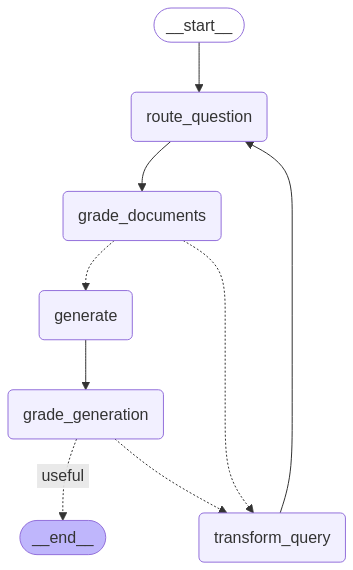

In [ ]:
from IPython.display import Image, display

try:
    display(Image(rag_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass